<a href="https://colab.research.google.com/github/JSSchouten/TM10007_Group_10/blob/master/Learning_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
'''
all necessary imports
'''
# general functions
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from pathlib import Path

# load data
from brats.load_data  import load_data

# preprocessing and scaling
from sklearn.model_selection    import train_test_split
from sklearn                    import preprocessing
from sklearn.decomposition      import PCA
from sklearn.feature_selection  import SelectKBest, f_classif

# classifiers
from sklearn.model_selection        import cross_val_score, learning_curve
from sklearn.neighbors              import KNeighborsClassifier
from sklearn.ensemble               import RandomForestClassifier
from sklearn                        import svm
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn.naive_bayes            import GaussianNB

# calculate accuracy values
from sklearn.metrics  import accuracy_score
from sklearn.metrics  import confusion_matrix

In [0]:
'''
Load the data from GitHub
'''

data = load_data()
data_columns = list(set(data))

In [0]:
'''
Learning curve function copied from assignment
'''


def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

In [0]:
'''
All other functions used
'''


def split(data):
  '''
  Divide data in a training and test set 80% - 20%
  '''
  x = data.iloc[:,:-1]
  y = data['label']
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

  return x_train, x_test, y_train, y_test


def delnan(x):
  '''
  Replace all values causing errors by NaN, and replace those and pre-
  existing NaNs by the column's median
  '''
  data_columns = list(set(x))
  ## Replace inf en -inf by NaN
  x_inf = x.replace([np.inf, -np.inf], np.nan)
  ## Replace strings by NaN
  x_str = (x_inf.drop(data_columns, axis=1)
             .join(x_inf[data_columns].apply(pd.to_numeric, errors='coerce')))
  ## Delete all columns containing over 50% NaN
  x_del_nan = x_str.dropna(axis='columns', thresh= round(0.5 * len(x_str)))
  ## Replace all NaNs with the column's median
  x_finished = x_del_nan.fillna(x_del_nan.median())

  return x_finished


def standardscaler(x_train, x_test):
  '''
  Scale all values using standard scaling
  '''
  ## Design scaler
  scaler = preprocessing.StandardScaler()
  # scaler = preprocessing.RobustScaler(quantile_range=[5, 95])
  scaler.fit(x_train)

  ## Apply scaler to both sets and return scaled sets
  x_scaled_train = scaler.transform(x_train)
  x_scaled_test = scaler.transform(x_test)

  x_scaled_df_train = pd.DataFrame(x_scaled_train, columns=x_train.columns)
  x_scaled_df_test = pd.DataFrame(x_scaled_test, columns=x_test.columns)

  return x_scaled_df_train, x_scaled_df_test


def select_features(x_train, x_test, y_train):
  '''
  Select discriminating features using PCA & univariate feature selection 
  '''
  ## PCA feature selection
  pca = PCA(n_components=None)
  pca.fit(x_train)

  variancelist = np.cumsum(pca.explained_variance_ratio_)
  # plt.figure(figsize=(12,8))
  # plt.plot(variancelist)
  # plt.xlabel('number of components')
  # plt.ylabel('cumulative explained variance');

  ## Determine the amount of features containing 75% of the variance
  comp = np.searchsorted(variancelist,0.75)

  pca_spec = PCA(n_components=comp)
  pca_spec.fit(x_train)
  
  ## Apply PCA to the different sets
  x_pca_train = pd.DataFrame(pca_spec.transform(x_train))
  x_pca_test = pd.DataFrame(pca_spec.transform(x_test))
  
  ## Select the five best features and apply them to the different sets
  Kbest = SelectKBest(f_classif, k=5).fit(x_train, y_train)
  x_Kbest_train = pd.DataFrame(Kbest.transform(x_train))
  x_Kbest_test = pd.DataFrame(Kbest.transform(x_test))

  ## determine the 5 used features
  feature_names = list(x_train.columns.values)
  mask = Kbest.get_support() #list of booleans
  used_features = [] # The list of the 5 best features

  for bool, feature in zip(mask, feature_names):
    if bool:
        used_features.append(feature)

  return x_pca_train, x_Kbest_train, x_pca_test, x_Kbest_test, used_features


def crosval (x_train, y_train, clfs):
  '''
   Determine classifier performance using cross-validation
  '''

  ## Start cross validation
  num = 0
  train_acc = []

  for clf in clfs:
    ## Plot learning curves
    fig = plt.figure(figsize=(24, 4*len(clfs)))
    ax=fig.add_subplot(4, 2, num + 1)
    num += 1
    plot_learning_curve(clf,str(type(clf)), x_train, y_train, axes=ax)

    ## Calculate performance
    scores = cross_val_score(clf, x_train, y_train, cv=5)
    print(f'{type(clf)}: {scores}')


def runscript (data_train, data_test, labels_train, labels_test, clfs):
  '''
  Run all the different functions needed for one iteration.
  '''
  x_train = delnan(data_train)
  x_test = delnan(data_test)
  x_scaled_train, x_scaled_test = standardscaler(x_train, x_test)
  x_pca_train, x_Kbest_train, x_pca_test, x_Kbest_test, features = select_features(x_scaled_train, x_scaled_test, labels_train)
  crosval(x_Kbest_train, labels_train, clfs)
  print('='*120)
  crosval(x_pca_train, labels_train, clfs)

<class 'sklearn.svm._classes.SVC'>: [0.85185185 0.85185185 0.88888889 1.         0.84615385]
<class 'sklearn.svm._classes.SVC'>: [0.85185185 0.88888889 0.92592593 1.         0.84615385]
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>: [0.85185185 0.88888889 0.92592593 1.         0.84615385]
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>: [0.81481481 0.88888889 0.88888889 0.96153846 0.84615385]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>: [0.85185185 0.92592593 0.92592593 1.         0.80769231]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>: [0.85185185 0.92592593 0.88888889 0.96153846 0.84615385]
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>: [0.85185185 0.88888889 0.88888889 1.         0.80769231]
<class 'sklearn.naive_bayes.GaussianNB'>: [0.81481481 0.85185185 0.88888889 1.         0.69230769]
<class 'sklearn.svm._classes.SVC'>: [0.7037037  0.85185185 0.81481481 0.76923077 0.73076923]
<class 'sklearn.svm

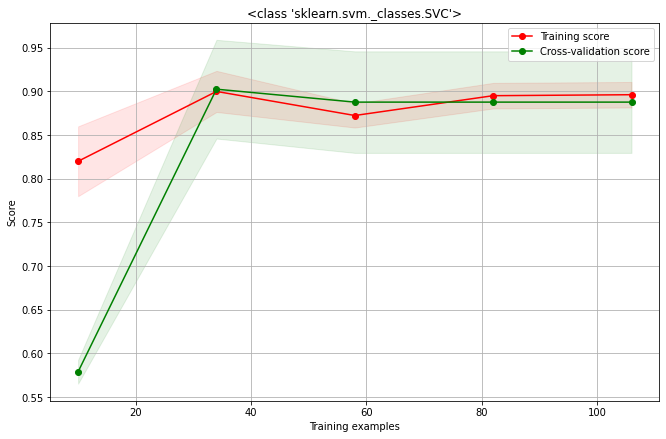

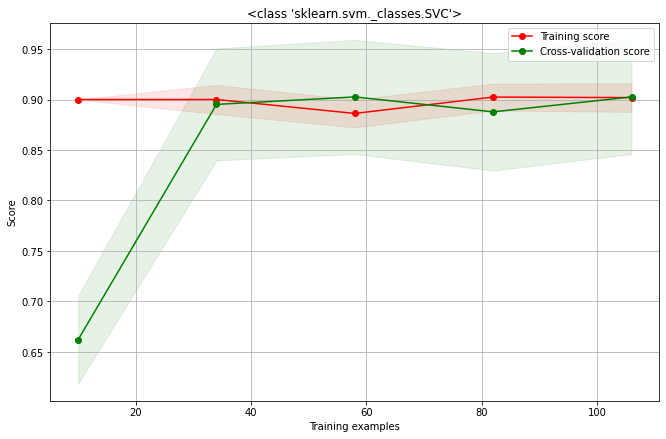

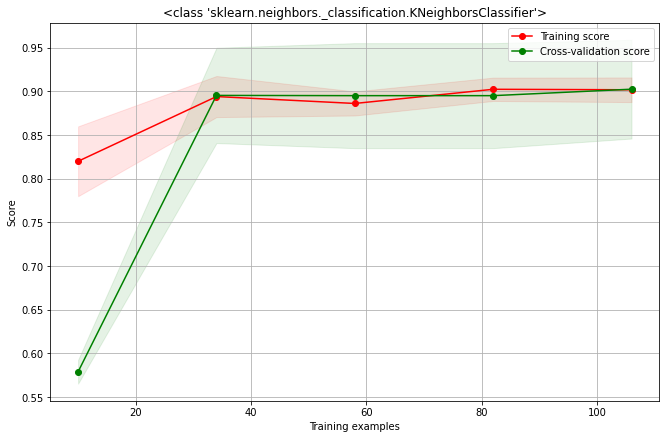

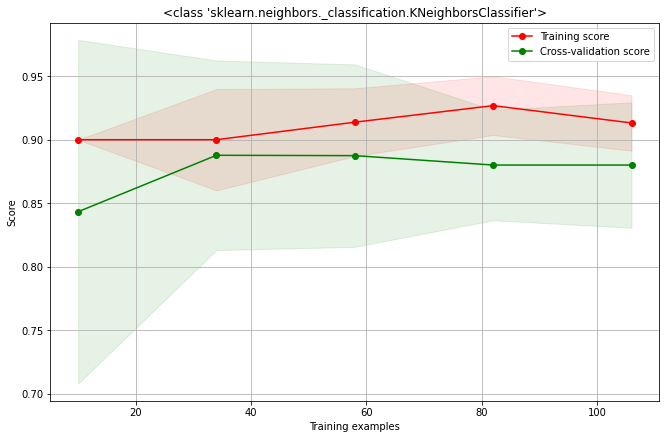

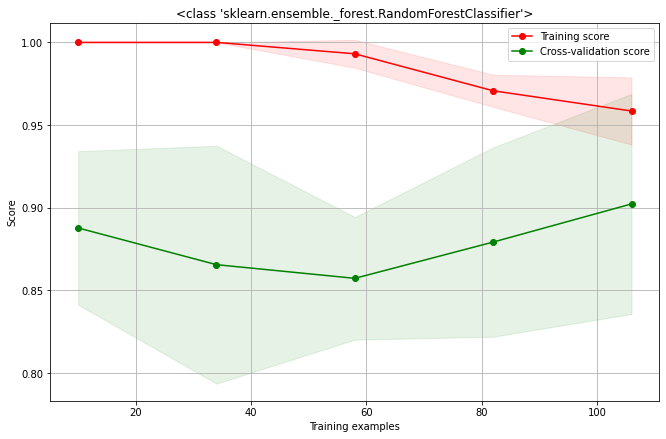

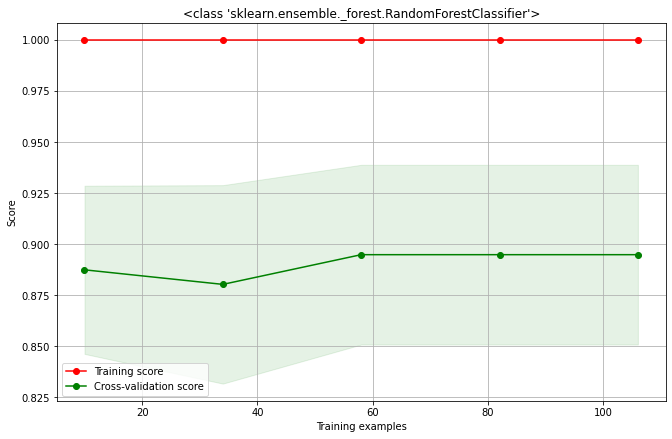

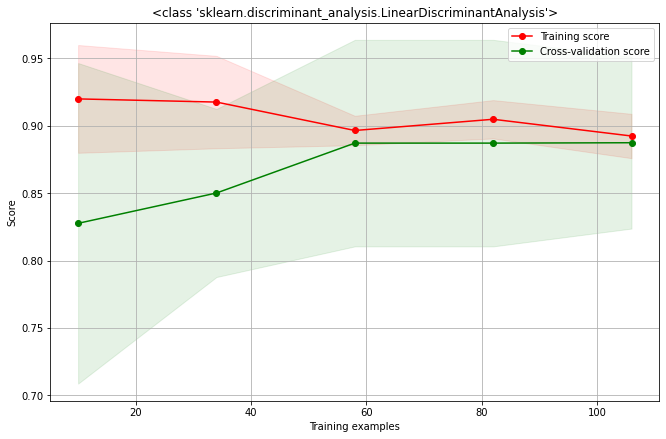

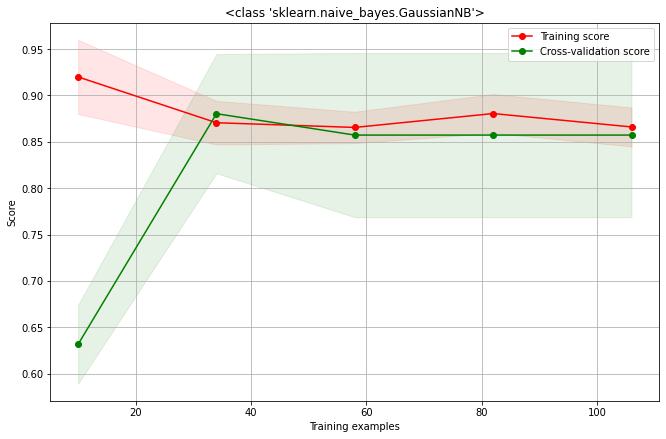

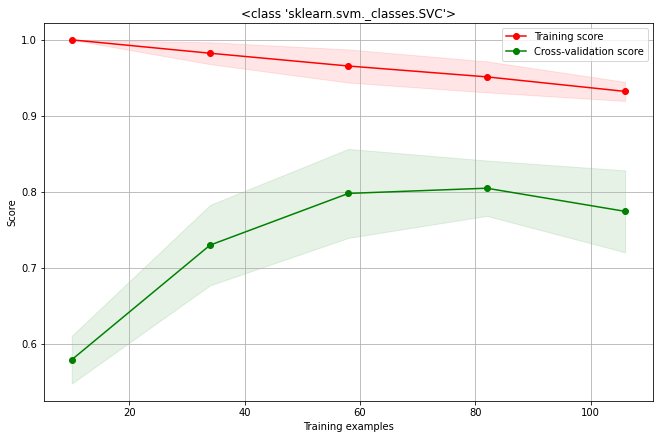

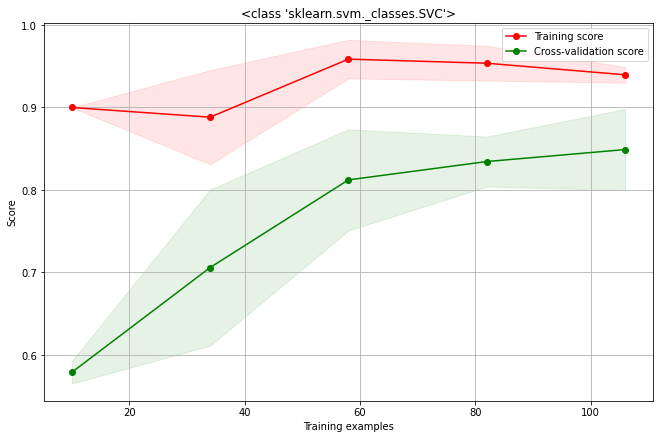

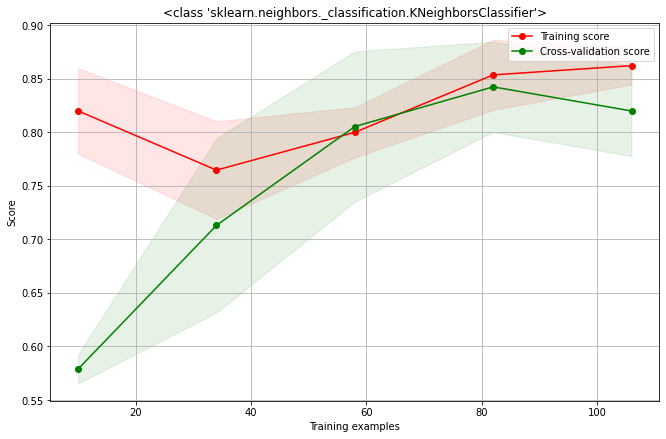

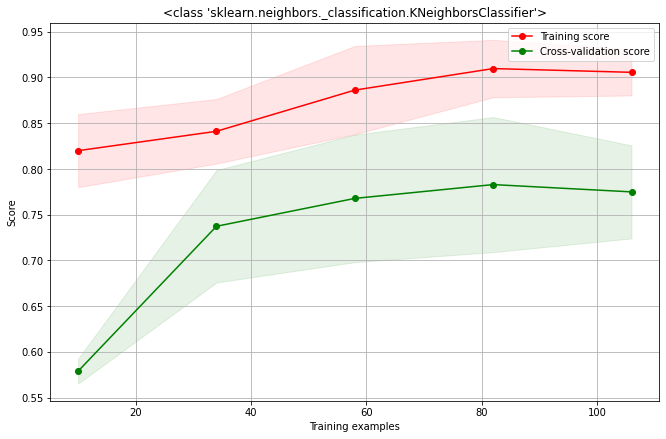

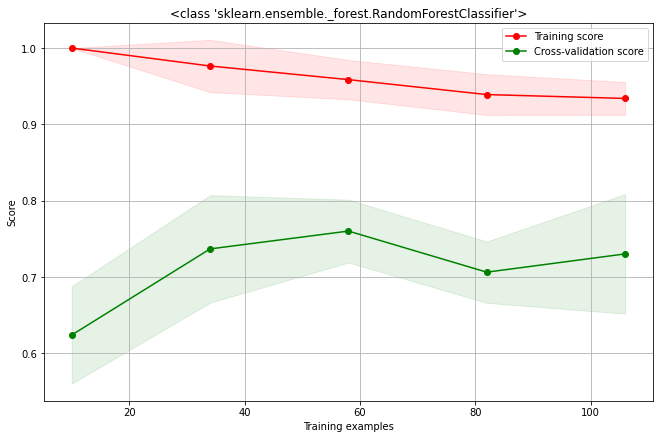

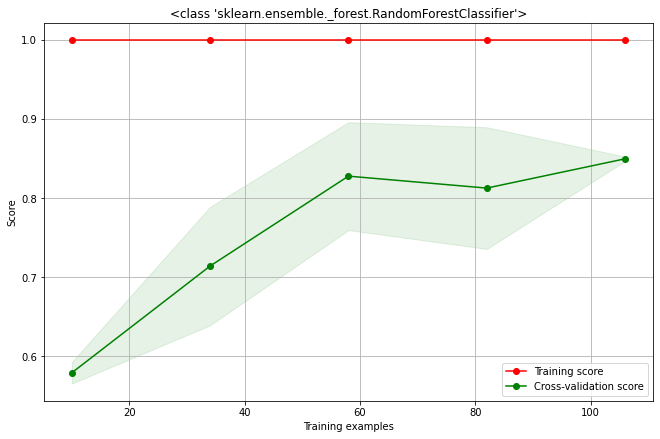

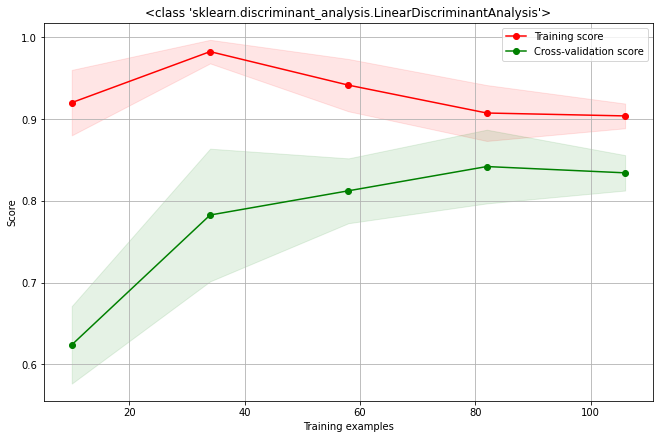

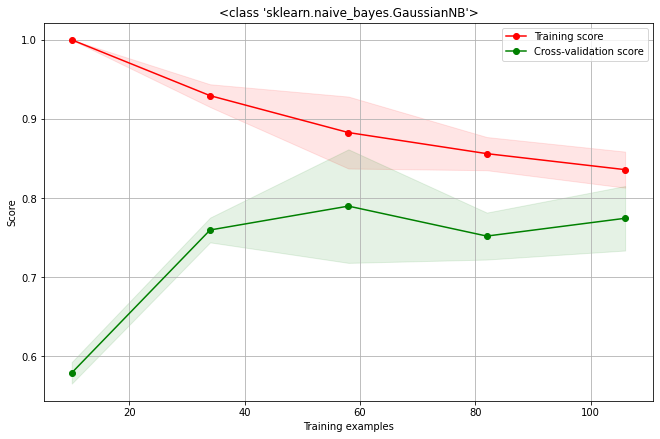

In [45]:
'''
run the different functions
'''
x_train, x_test, y_train, y_test = split(data)

## define the classifiers to evaluate
clfs = [svm.SVC(C=0.05 ,kernel='linear'), 
        svm.SVC(C=0.8 ,kernel='rbf'), 
        KNeighborsClassifier(n_neighbors=9), 
        KNeighborsClassifier(n_neighbors=3), 
        RandomForestClassifier(n_estimators=5, random_state=42, max_depth=4), 
        RandomForestClassifier(random_state=42),
        LinearDiscriminantAnalysis(),
        GaussianNB()
        ]
score = runscript(x_train, x_test, y_train, y_test, clfs)
